# Final Project - Bayesian model selection

In [1]:
import arviz as az
import numpy as np
import pymc3 as pm

from matplotlib import pyplot as plt
from scipy.special import betaln
from scipy.stats import beta

In [2]:

np.random.seed(11)           # for reproducibility
a=0.25                       # biased coin
flips=np.random.rand(2**12)  # simulates 4096 coin flips
heads=flips<a    # boolean array, heads[i]=True if flip i is heads
np.sum(heads)

983

Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.385
Stage:   1 Beta: 1.000
Stage:   0 Beta: 0.394
Stage:   1 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 1.000
Stage:   0 Beta: 1.000


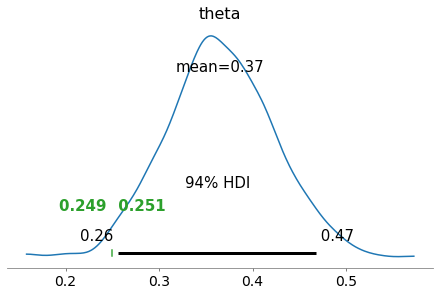

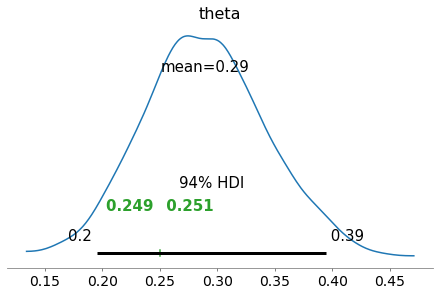

In [3]:
with pm.Model() as model1: #model of a fair coin
    theta = pm.Normal("theta",mu=.5,sigma=.1) #prior for the parameter theta
    yl = pm.Bernoulli("yl", theta, observed=heads[:50]) #likelihood given the measured data
    trace1 = pm.sample_smc(1000, random_seed=42, parallel=False) #sample from posterior
with pm.Model() as model2: #model of biased coin  
    theta = pm.Normal("theta",mu=.25,sigma=.1) #prior for the parameter theta
    yl = pm.Bernoulli("yl", theta, observed=heads[:50]) #likelihood given the measured data
    trace2 = pm.sample_smc(1000, random_seed=42, parallel=False) #sample from posterior
with model1:
    az.plot_posterior(trace1,rope=[0.249,0.251])
with model2:
    az.plot_posterior(trace2,rope=[0.249,0.251])


In [4]:
theta_array=trace1["theta"]
norm_const=len(trace1["theta"])
BF_smc = np.exp(trace2.report.log_marginal_likelihood - trace1.report.log_marginal_likelihood)#bayes factor
BF_smc

array([3.47885066, 3.52248701])

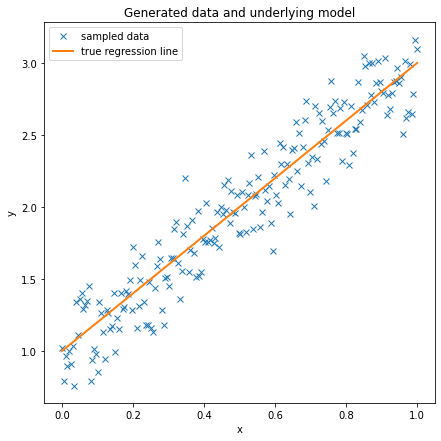

In [5]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=0.2, size=size)

data = dict(x=x, y=y)
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);


In [6]:
sampleSize = 3000

with pm.Model() as lin_model:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
    intercept = pm.Normal("Intercept", 0, sigma=20)
    m = pm.Normal("m", 0, sigma=20)
    
    mu = pm.Deterministic('mu', intercept + m * x)
    # Define likelihood
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)

    # Inference!
    lin_trace =  pm.sample_smc(sampleSize, random_seed=42, parallel=False) 

with pm.Model() as const_model:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
    intercept = pm.Normal("Intercept", 0, sigma=20)
    #x_coeff = pm.Normal("x", 0, sigma=20)

    # Define likelihood
    mu = pm.Deterministic('mu', intercept+x*0)
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)

    # Inference!
    const_trace =  pm.sample_smc(sampleSize, random_seed=42, parallel=False) 
    
with pm.Model() as sq_model:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
    intercept = pm.Normal("Intercept", 0, sigma=20)
    #x_coeff = pm.Normal("x", 0, sigma=20)
    a = pm.Normal("a", 0, sigma=20)
    b = pm.Normal("b", 0, sigma=20)
    
    # Define likelihood
    mu = pm.Deterministic('mu', intercept+x*b+a*x**2)
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)

    # Inference!
    sq_trace =  pm.sample_smc(sampleSize, random_seed=42, parallel=False) 
    

Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.003
Stage:   1 Beta: 0.008
Stage:   2 Beta: 0.012
Stage:   3 Beta: 0.019
Stage:   4 Beta: 0.027
Stage:   5 Beta: 0.038
Stage:   6 Beta: 0.058
Stage:   7 Beta: 0.090
Stage:   8 Beta: 0.145
Stage:   9 Beta: 0.269
Stage:  10 Beta: 0.574
Stage:  11 Beta: 1.000
Stage:   0 Beta: 0.003
Stage:   1 Beta: 0.007
Stage:   2 Beta: 0.012
Stage:   3 Beta: 0.018
Stage:   4 Beta: 0.027
Stage:   5 Beta: 0.038
Stage:   6 Beta: 0.057
Stage:   7 Beta: 0.092
Stage:   8 Beta: 0.161
Stage:   9 Beta: 0.326
Stage:  10 Beta: 0.780
Stage:  11 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.003
Stage:   1 Beta: 0.007
Stage:   2 Beta: 0.012
Stage:   3 Beta: 0.022
Stage:   4 Beta: 0.050
Stage:   5 Beta: 0.144
Stage:   6 Beta: 0.466
Stage:   7 Beta: 1.000
Stage:   0 Beta: 0.003
Stage:   1 Beta: 0.007
Stage:   2 Beta: 0.012
Stage:   3 Beta: 0.021
Stage:   4 Beta: 0.049
Stage:   5 Beta: 0.142
Stage:   6 Bet

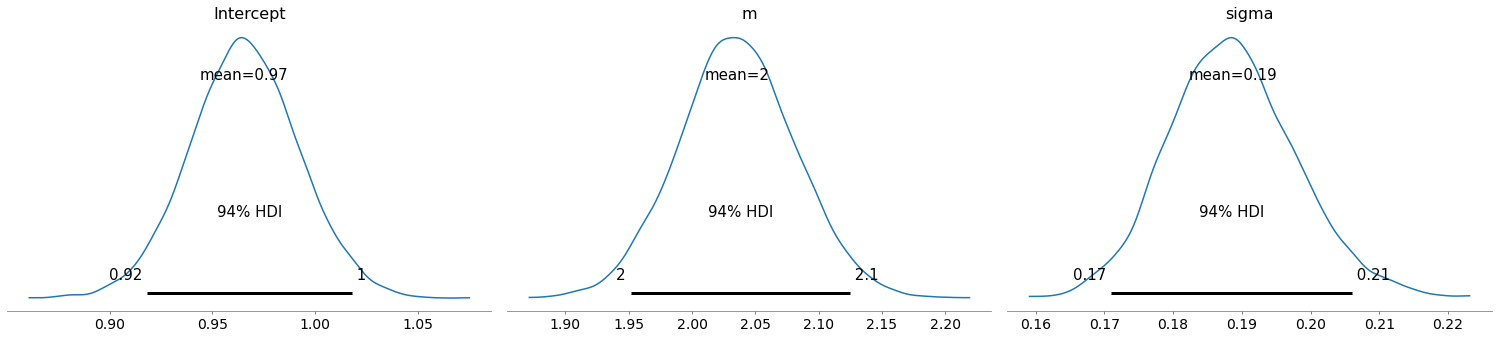

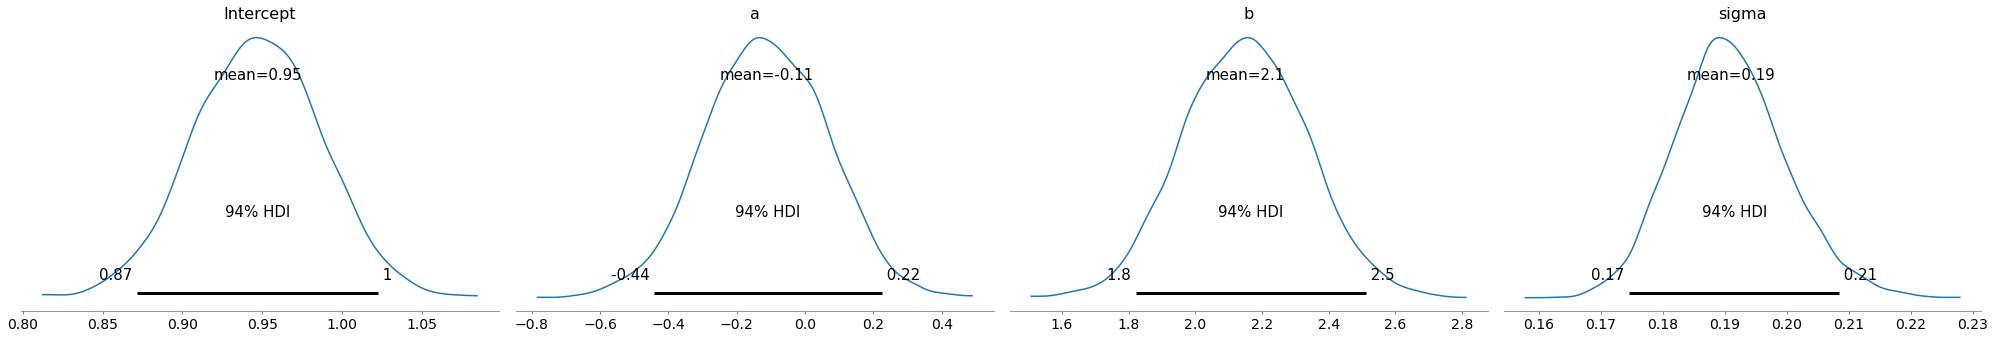

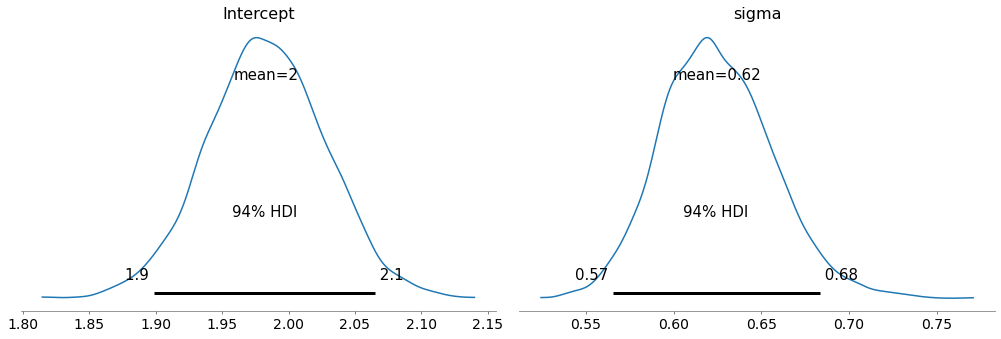

In [7]:
with lin_model:
    az.plot_posterior(lin_trace, var_names=['Intercept', 'm', 'sigma'])

with sq_model:
    az.plot_posterior(sq_trace, var_names=['Intercept', 'a', 'b','sigma'])    

with const_model:
    az.plot_posterior(const_trace, var_names=['Intercept', 'sigma'])
    
    

/home/jakob/.local/lib/python3.9/site-packages/arviz/utils.py:660: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(
/home/jakob/.local/lib/python3.9/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/jakob/.local/lib/python3.9/site-packages/arviz/utils.py:660: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(
/home/jakob/.local/lib/python3.9/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/jakob/.local/lib/python3.9/site-packages/arviz/utils.py:660: UserWarning: Keyword argument credible_interval has been deprecated Please 

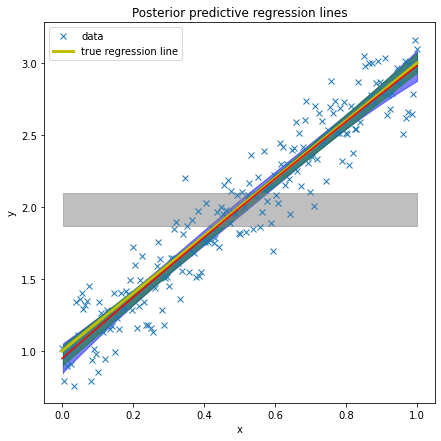

In [8]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, "x", label="data")
#pm.plot_posterior_predictive_glm(lin_trace, samples=100, label="posterior predictive regression lines")
plt.plot(x, true_regression_line, label="true regression line", lw=3.0, c="y")

plt.title("Posterior predictive regression lines")
plt.legend(loc=0)
plt.xlabel("x")
plt.ylabel("y");
sig2 = az.plot_hpd(x, sq_trace['mu'], credible_interval=.99, color='b')
sig1 = az.plot_hpd(x, lin_trace['mu'], credible_interval=.99, color='g')
plt.plot(x, np.mean(sq_trace['Intercept'])+np.mean(sq_trace['a'])*x**2+np.mean(sq_trace['b'])*x, color='red')
sig3 = az.plot_hpd(x, const_trace['mu'], credible_interval=.99, color='gray')


In [9]:
def Bayes_Factor(trace1, trace2):
    return  np.exp(trace1.report.log_marginal_likelihood - trace2.report.log_marginal_likelihood)#bayes factor

Bayes_Factor(lin_trace, sq_trace)


array([  2798.33097457, 187030.99011547])

## Bayes Complexity

In [25]:
#for now lets assume we look at a polynomial of degree n

def poly_model(x,params): #params is array from highest order to lowest order of coefficents
    order=len(params)
    y=0
    for i in range(order):
        y+=x**i*params[-i-1]
        #print(params[-i-1])
    return y

def logli(sigma,datapoints,model,params):
    loglikelihood=-N/2*np.log(2*np.pi)*np.sum(-1*np.log(sigma))
    tmp=0
    for i in range(len(datapoints)):
        tmp+=(datapoints[i]-model(datapoints[i],params))**2/(sigma[i]**2)
    loglikelihood+=-1/2*tmp

def bayes_complexity(sigma,datapoints,model,params,trace):#params is a list of strings with parameter NAMES
    param_means=[np.mean(trace[params[i]])for i in len(params)]
    param_samples=[trace[params[i]] for i in len(params)]
    #to do: average of loglikelihood with respect to param_samples
    return 0

def marginal_likelihood():
    return 0

params=['a','b','Intercept','sigma']
param_means=[np.mean(sq_trace[params[i]])for i in range(len(params))]
param_means

[-0.11362386630990552,
 2.1482710672467613,
 0.9471911444238417,
 0.19099734521488637]

## Experimental.... not working

In [34]:
sampleSize = 10000
x = np.linspace(-1, 1, size)
# y = a + b*x
true_regression_line = 2*np.sin(x+0)+1
# add noise
y = true_regression_line + np.random.normal(scale=0.2, size=size)
with pm.Model() as sin_model:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
    A = pm.Normal("A",0, sigma=20)
    omega = pm.Normal("omega", 0, sigma=20)
    phi = pm.Normal("phi", 0, sigma=20)
    intercept = pm.Normal("intercept", 0, sigma=20)

    # Define likelihood
    sin = pm.Deterministic('sin', A*np.sin(omega*x+phi)+intercept)
    likelihood = pm.Normal("y", mu=sin, sigma=sigma, observed=y)

    # Inference!
    sin_trace =  pm.sample(sampleSize, random_seed=42) #parallel=False) 
    

/home/jakob/.local/lib/python3.9/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, phi, omega, A, sigma]


/home/jakob/.local/lib/python3.9/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/home/jakob/.local/lib/python3.9/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 45 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.884456875774161, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some paramet

/home/jakob/.local/lib/python3.9/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'omega'}>,
        <AxesSubplot:title={'center':'phi'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'intercept'}>, <AxesSubplot:>]],
      dtype=object)

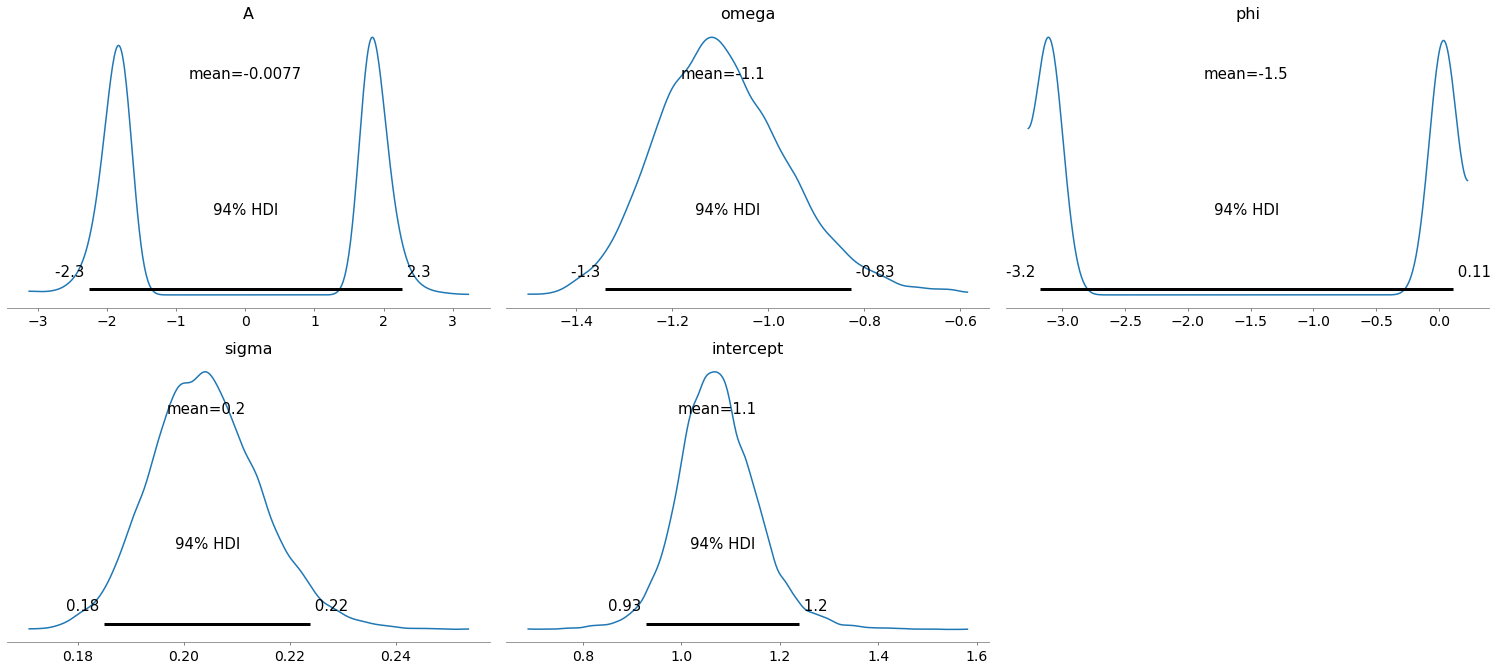

In [35]:
az.plot_posterior(sin_trace, var_names=['A', 'omega', 'phi', 'sigma','intercept'])


In [ ]:
x = np.linspace(-5, 5, size)
# y = a + b*x
true_regression_line = 3*np.exp(-(x-0)**2/(2*1**2))
# add noise
y = true_regression_line + np.random.normal(scale=0.3, size=size)
plt.plot(x,y, "x")
plt.plot(x, true_regression_line)
sig1 = az.plot_hpd(x, gauss_trace['gauss'], credible_interval=.99, color='g')


In [ ]:
x=np.linspace(-1,1,100)
y=poly_model(x,[1,2,3])
sq_trace
plt.plot(x,y,'b--',x,x**2+2*x+3,'r-.')
plt.show()